# Predicting Parkinson's Disease Progression Using Machine Learning
#Inputs: Peptide dataset + Protein dataset + Clinical dataset

#Steps

1 - Data Cleaning and Transformation
#-merging, pivots...

2 - Feature engineering and feature selection 
#- log-scale features,impute missing values
#- explore Random Forest and Mutual information feature selection mtds

3 - Modeling: XGBoost Regressor, Random Forest Regressor,
Decision Tree Regressor, Lasso Regressor
#- hyperparameter tuning via Gridsearch
#- walk forward cross validation (time series data)

4 - Validation/Testing

In [ ]:
#! pip install stepwise-regression

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from stepwise_regression import step_reg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import TimeSeriesSplit

In [3]:
#importing files
peptides = pd.read_csv("train_peptides.csv")
proteins = pd.read_csv("train_proteins.csv")

In [4]:
#reading clinical data and imputing missing values
clinical  = pd.read_csv("train_clinical_data.csv")
clinical['updrs_1'] = clinical['updrs_1'].fillna(clinical['updrs_1'].median())
clinical['updrs_2'] = clinical['updrs_2'].fillna(clinical['updrs_2'].median())
clinical['updrs_3'] = clinical['updrs_3'].fillna(clinical['updrs_3'].median())
clinical['upd23b_clinical_state_on_medication'] = clinical['upd23b_clinical_state_on_medication'].fillna('unreported')

In [2]:
#EDA -> feature selection and feature engineering -> models -> metrics 

understanding distribution of clinical dataset

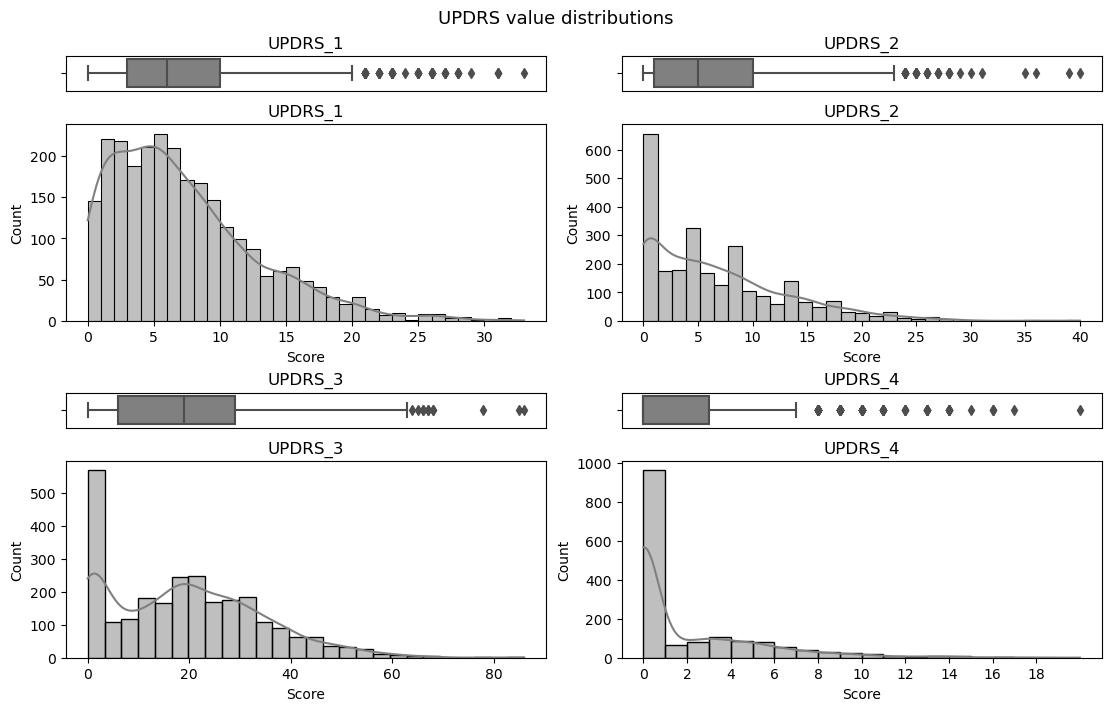

In [5]:

clinical_data = clinical.copy()

colors = ['grey']
sns.set_palette(sns.color_palette(colors))

f, axes = plt.subplots(4, 2, layout="constrained",
                        gridspec_kw={"height_ratios": (.15, .85, .15, .85)}, figsize=(11, 7))

f.suptitle('UPDRS value distributions', fontsize=13)

splot = sns.boxplot(ax=axes[0][0], x=clinical_data['updrs_1'])
splot.axes.get_xaxis().set_visible(False)
splot.set_title('UPDRS_1')

splot = sns.boxplot(ax=axes[0][1], x=clinical_data['updrs_2'])
splot.axes.get_xaxis().set_visible(False)
splot.set_title('UPDRS_2')

splot = sns.boxplot(ax=axes[2][0], x=clinical_data['updrs_3'])
splot.axes.get_xaxis().set_visible(False)
splot.set_title('UPDRS_3')

splot = sns.boxplot(ax=axes[2][1], x=clinical_data['updrs_4'])
splot.axes.get_xaxis().set_visible(False)
splot.set_title('UPDRS_4')

splot = sns.histplot(ax=axes[1][0], x=clinical_data['updrs_1'], kde=True, alpha=0.5, ec='black')
splot.set_xlabel('Score')
splot.set_ylabel('Count')
splot.set_title('UPDRS_1')


splot = sns.histplot(ax=axes[1][1], x=clinical_data['updrs_2'], kde=True, alpha=0.5, ec='black')
splot.set_xlabel('Score')
splot.set_ylabel('Count')
splot.set_title('UPDRS_2')

splot = sns.histplot(ax=axes[3][0], x=clinical_data['updrs_3'], kde=True, alpha=0.5, ec='black')
splot.set_xlabel('Score')
splot.set_ylabel('Count')
splot.set_title('UPDRS_3')

splot = sns.histplot(ax=axes[3][1], x=clinical_data['updrs_4'], kde=True, bins=range(0, 20), alpha=0.5, ec='black')

splot.set_xticks(range(0, 20, 2))
splot.set_xlabel('Score')
splot.set_ylabel('Count')
splot.set_title('UPDRS_4')

f.savefig('updrs_kde.tiff')

understanding relationship between disease score and visit month

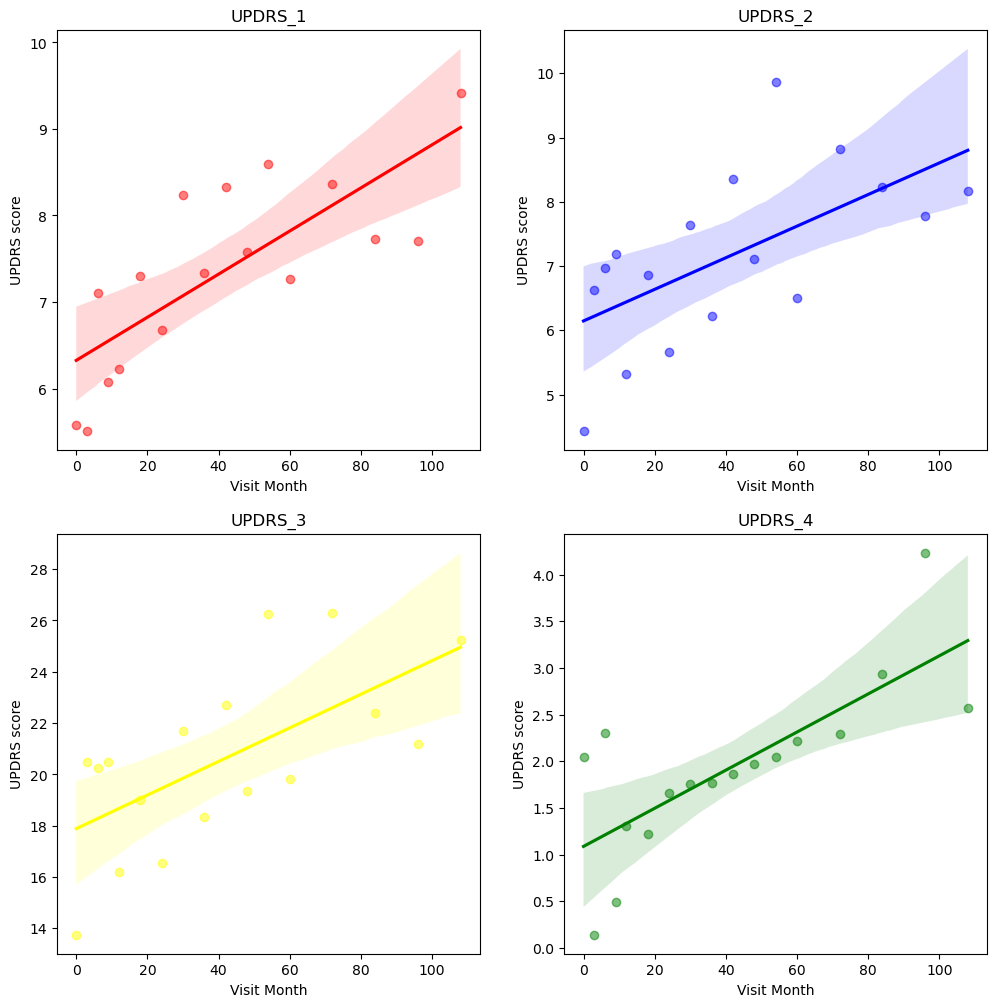

In [6]:


clinical_data.groupby('visit_month').mean()['updrs_1']

f, axes = plt.subplots(2, 2, figsize=(12, 12))

#f.suptitle('UPDRS mean distributions', fontsize=13)

splot = sns.regplot(ax=axes[0][0], x='visit_month', y='updrs_1', data=clinical_data.groupby('visit_month', as_index=False).mean(),
                    color='red', scatter_kws={'alpha': 0.5})
splot.set_xlabel('Visit Month')
splot.set_ylabel('UPDRS score')
splot.set_title('UPDRS_1')

splot = sns.regplot(ax=axes[0][1], x='visit_month', y='updrs_2', data=clinical_data.groupby('visit_month', as_index=False).mean(),
                    color='blue', scatter_kws={'alpha': 0.5})
splot.set_xlabel('Visit Month')
splot.set_ylabel('UPDRS score')
splot.set_title('UPDRS_2')

splot = sns.regplot(ax=axes[1][0], x='visit_month', y='updrs_3', data=clinical_data.groupby('visit_month', as_index=False).mean(),
                    color='yellow', scatter_kws={'alpha': 0.5})
splot.set_xlabel('Visit Month')
splot.set_ylabel('UPDRS score')
splot.set_title('UPDRS_3')

splot = sns.regplot(ax=axes[1][1], x='visit_month', y='updrs_4', data=clinical_data.groupby('visit_month', as_index=False).mean(),
                    color='green', scatter_kws={'alpha': 0.5})
splot.set_xlabel('Visit Month')
splot.set_ylabel('UPDRS score')
splot.set_title('UPDRS_4')
#axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
#axes[1].locator_params(axis='y', nbins=6)



plt.show()

In [ ]:
clinical.head()

understanding relationship between prediction score and medication status

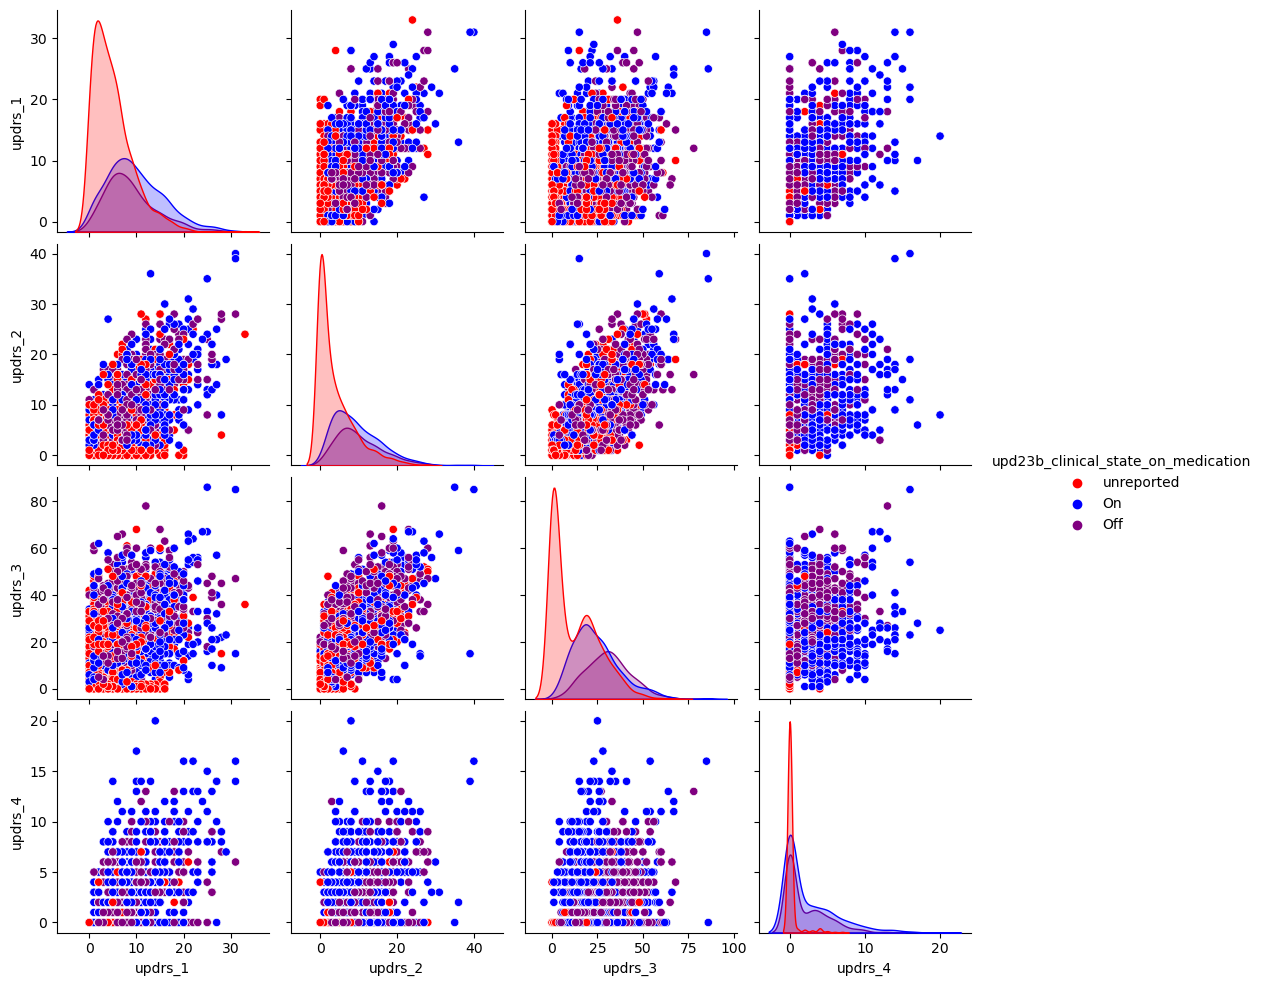

In [7]:
colors = ["red", "blue", "purple"]
sns.set_palette(sns.color_palette(colors))
f = sns.pairplot(clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4','upd23b_clinical_state_on_medication']], hue="upd23b_clinical_state_on_medication")
f.savefig('pairplot.tiff')

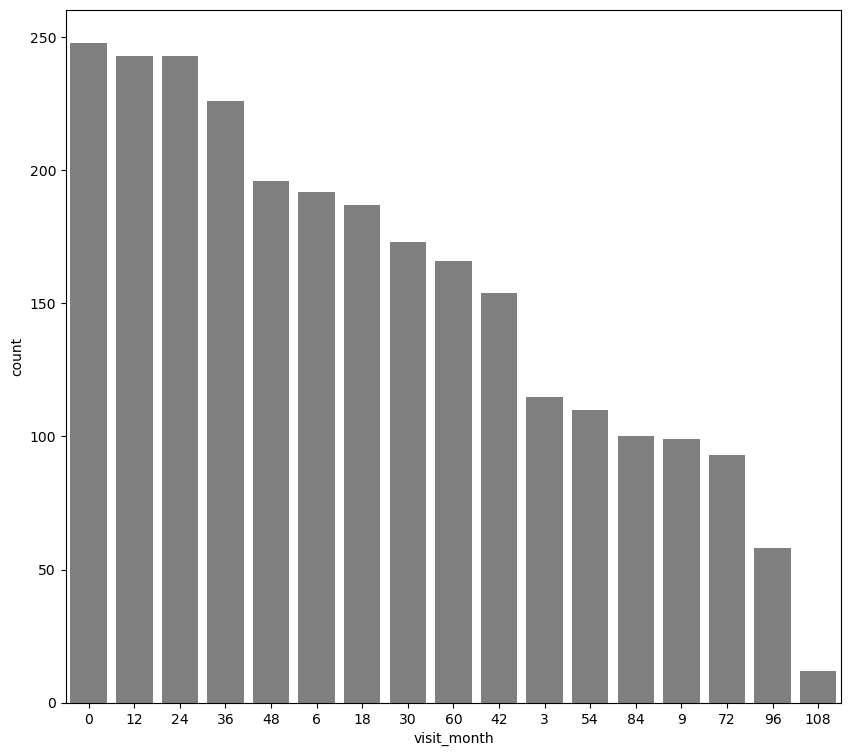

In [8]:
#sns.set(style='darkgrid')
#sns.set_palette(sns.color_palette("red"))
f = plt.figure(figsize=(10,9))
sns.countplot( x="visit_month",data=clinical,order = clinical['visit_month'].value_counts().index,
             color="grey")
f.savefig('freqvisitpertimepoint.tiff')
#plt.show()

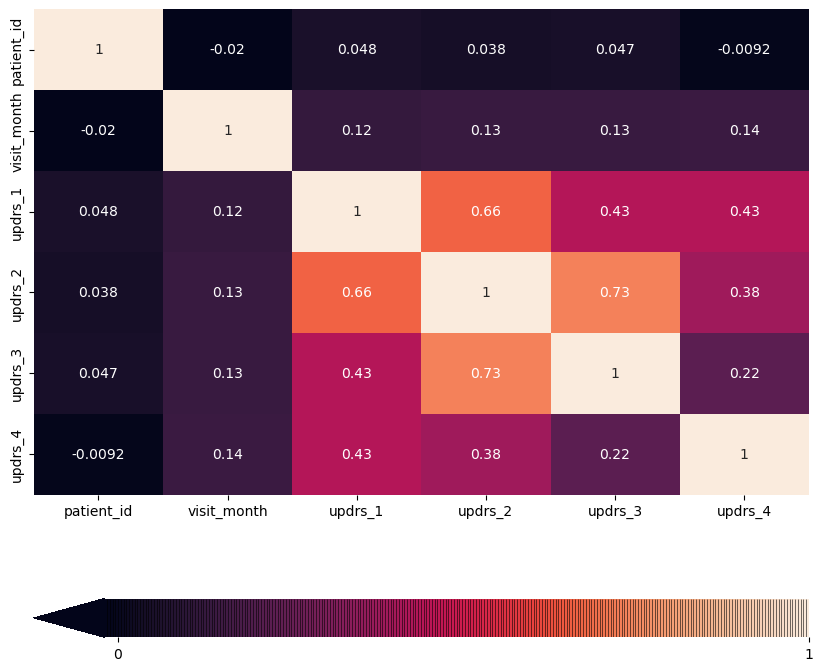

In [9]:
f = plt.figure(figsize=(10,9))
cbar_kws={
    'orientation':'horizontal',
    'shrink':1,
    'extend':'min',
    'extendfrac':0.1,
    'ticks':np.arange(0,22),
    'drawedges':True
}
sns.heatmap(clinical.corr(),annot=True,cbar_kws=cbar_kws)
f.savefig('correlations.tiff')

In [10]:
def visualize_continuous_data_histogram(df, column, log_scale=False, pltname = ""):
   
    fig, ax = plt.subplots(figsize=(18,12), dpi=100)
    x = df[column]
    if log_scale:
        x = np.log(x)
    sns.histplot(x, fill=True, log_scale=False, ax=ax, color='grey')
    ax.tick_params(axis='x', labelsize=12.5)
    ax.tick_params(axis='y', labelsize=12.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    title = f'''
    {column}
    Mean: {df[column].mean():.2f}
    Median: {df[column].median():.2f}
    Std: {df[column].std():.2f}
    Min: {df[column].min():.2f}
    Max: {df[column].max():.2f}
    '''
    ax.set_title(title, size=20, pad=12.5)
    plt.tight_layout()
    fig.savefig(pltname)
    plt.show()

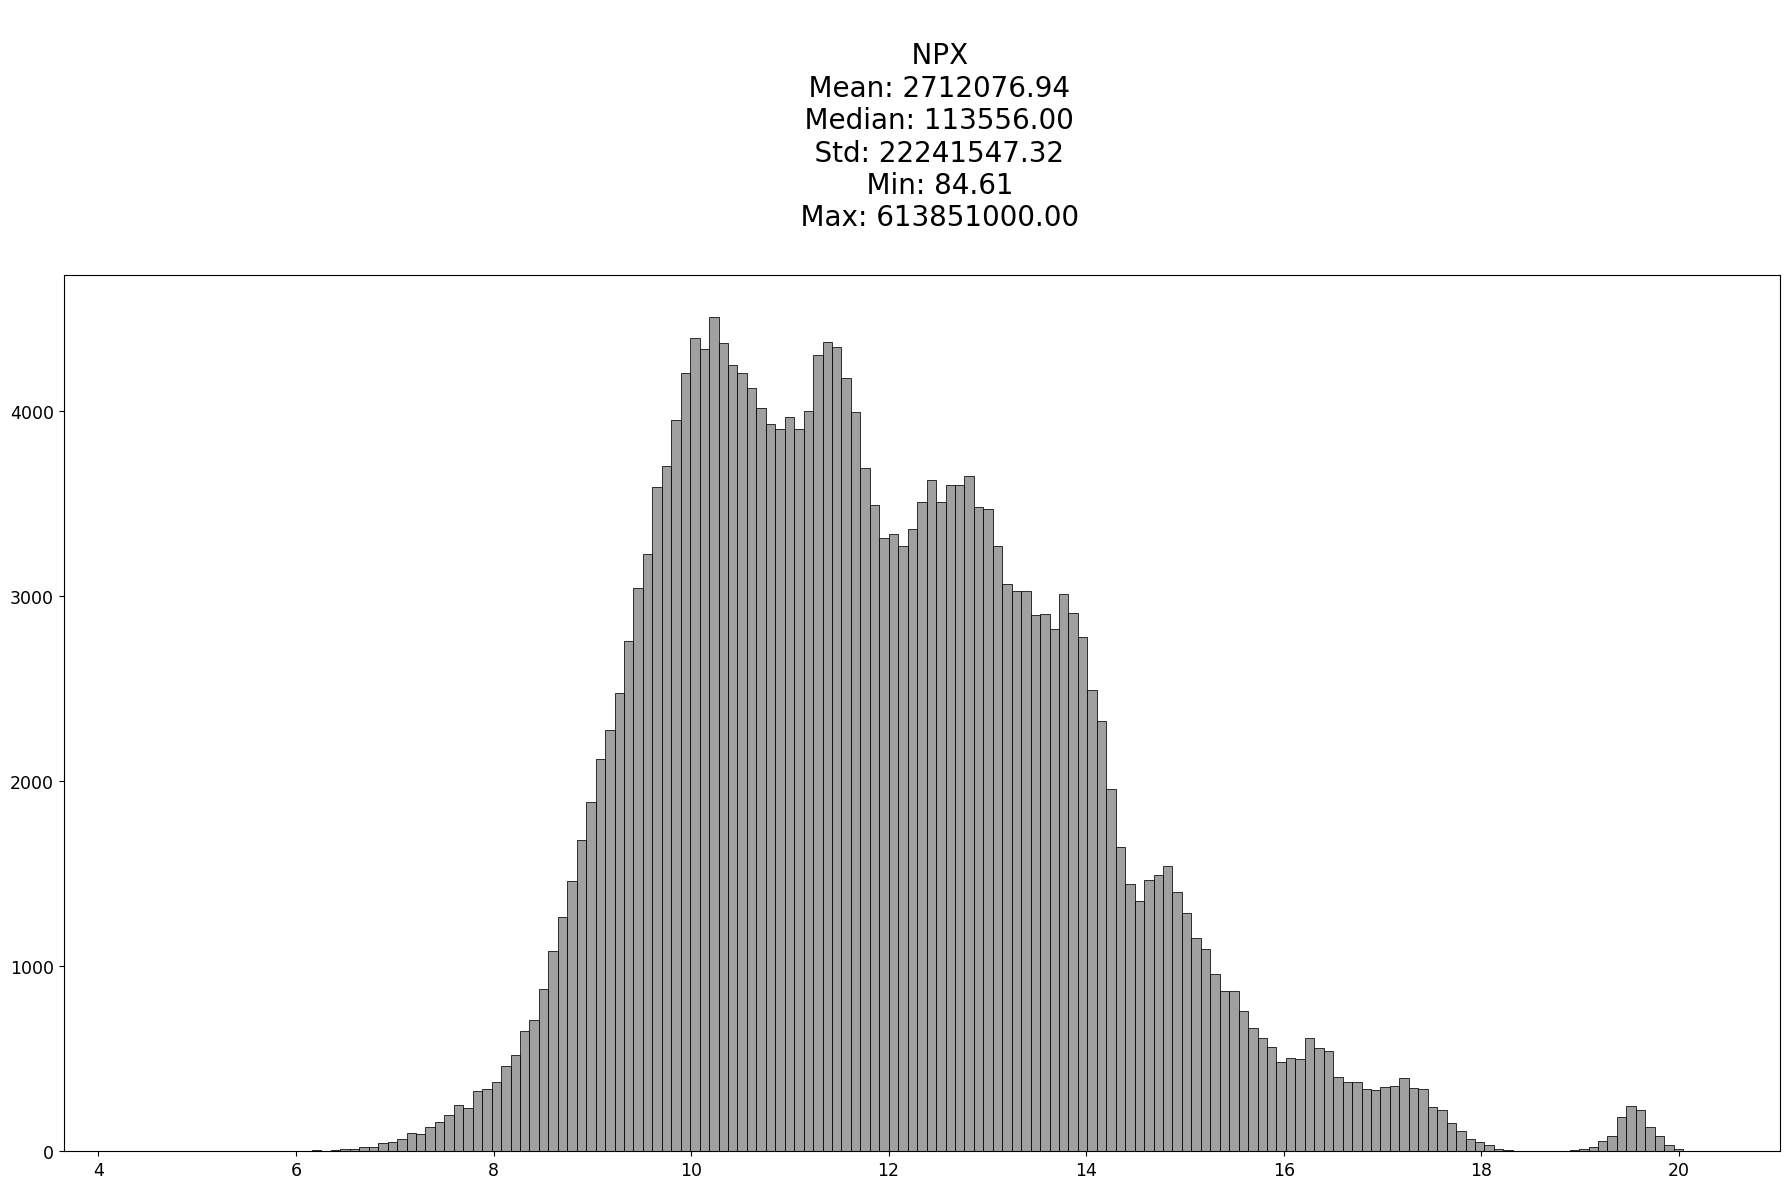

In [11]:
#now - Peptides and Proteins EDA section
#Proteins
visualize_continuous_data_histogram(df=proteins, column='NPX', log_scale=True,pltname = "proteindist.tiff")

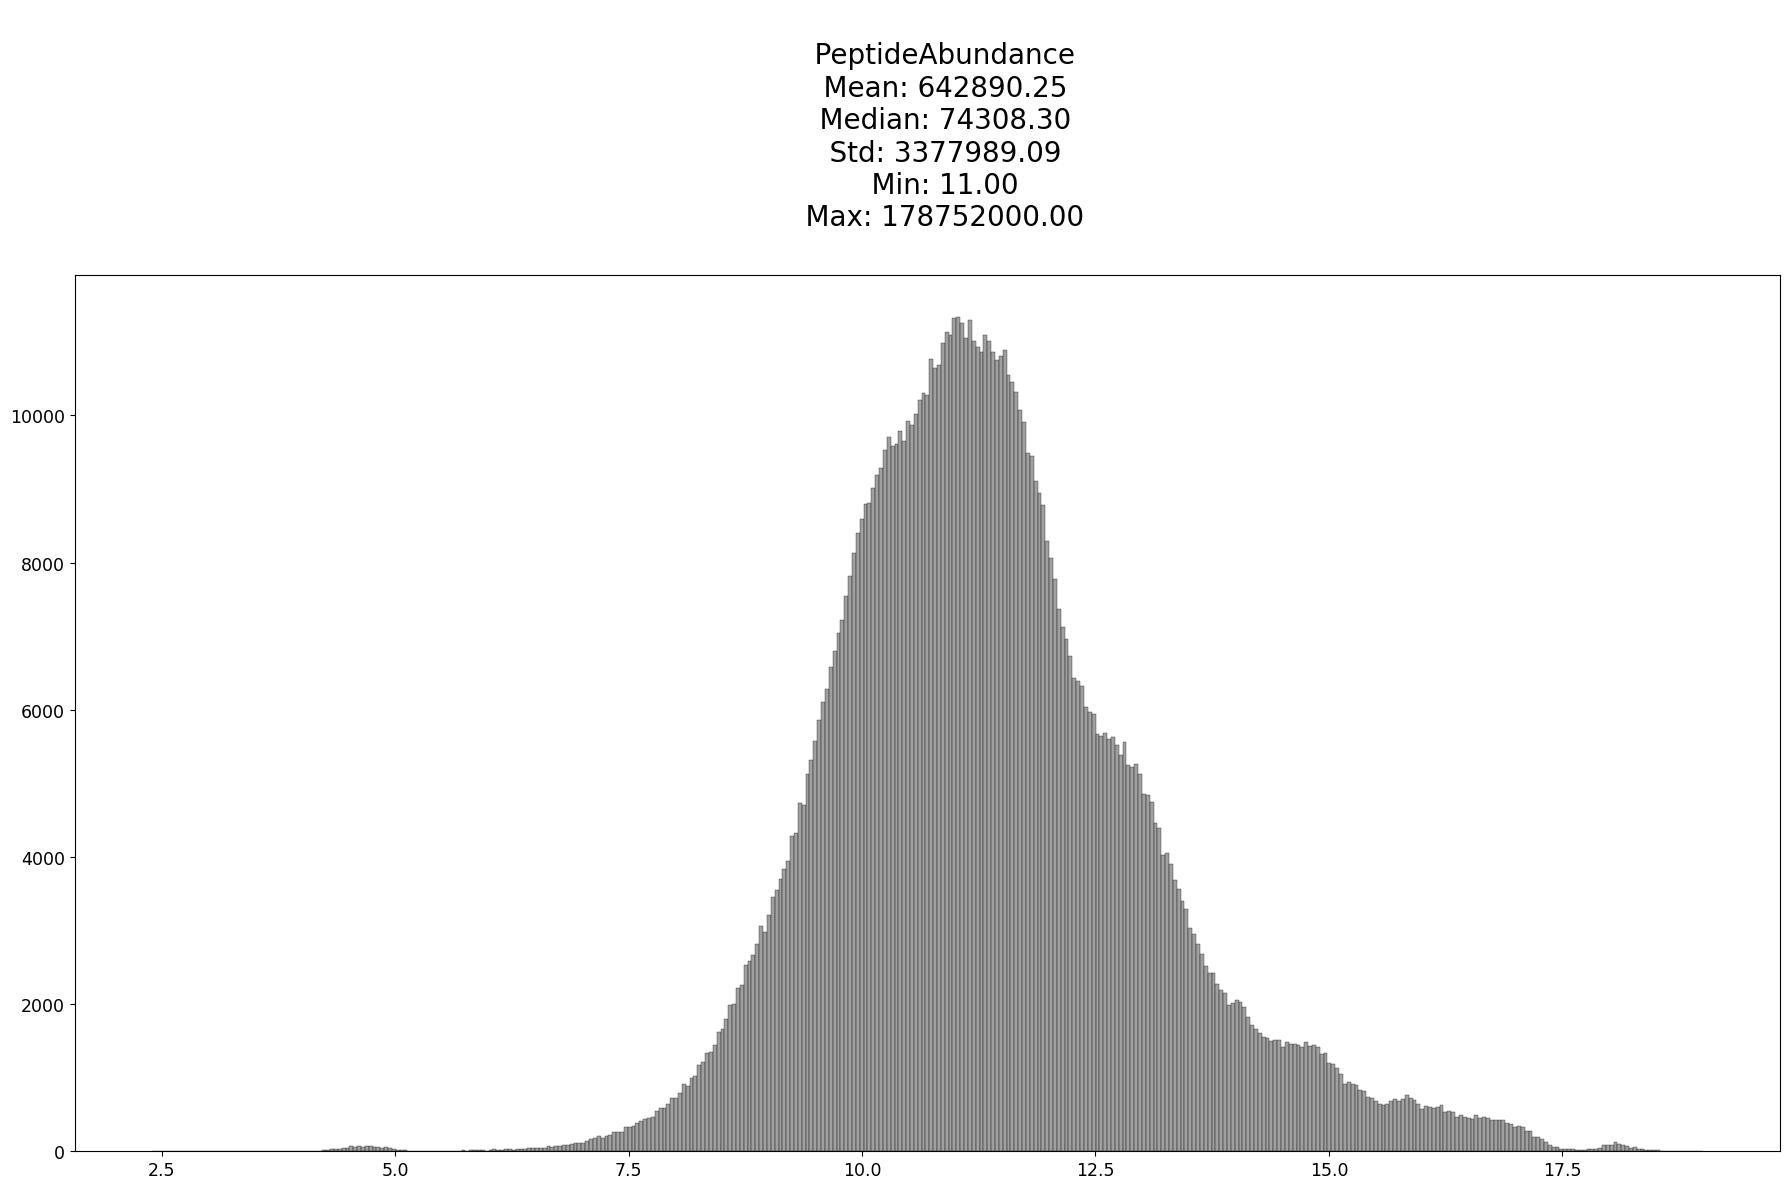

In [12]:
#Peptides
visualize_continuous_data_histogram(df=peptides, column='PeptideAbundance', log_scale=True, pltname="peptidedist.tiff")

In [13]:
def visualize_value_counts(value_counts, title, pltname=""):
            
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    ax.barh(range(len(value_counts)), value_counts.values(), align='center', color='grey')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(range(len(value_counts)))
    ax.set_yticklabels([f'{x} ({value_count:,})' for x, value_count in value_counts.items()])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(title, size=20, pad=15)
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    fig.savefig(pltname)
    plt.show()

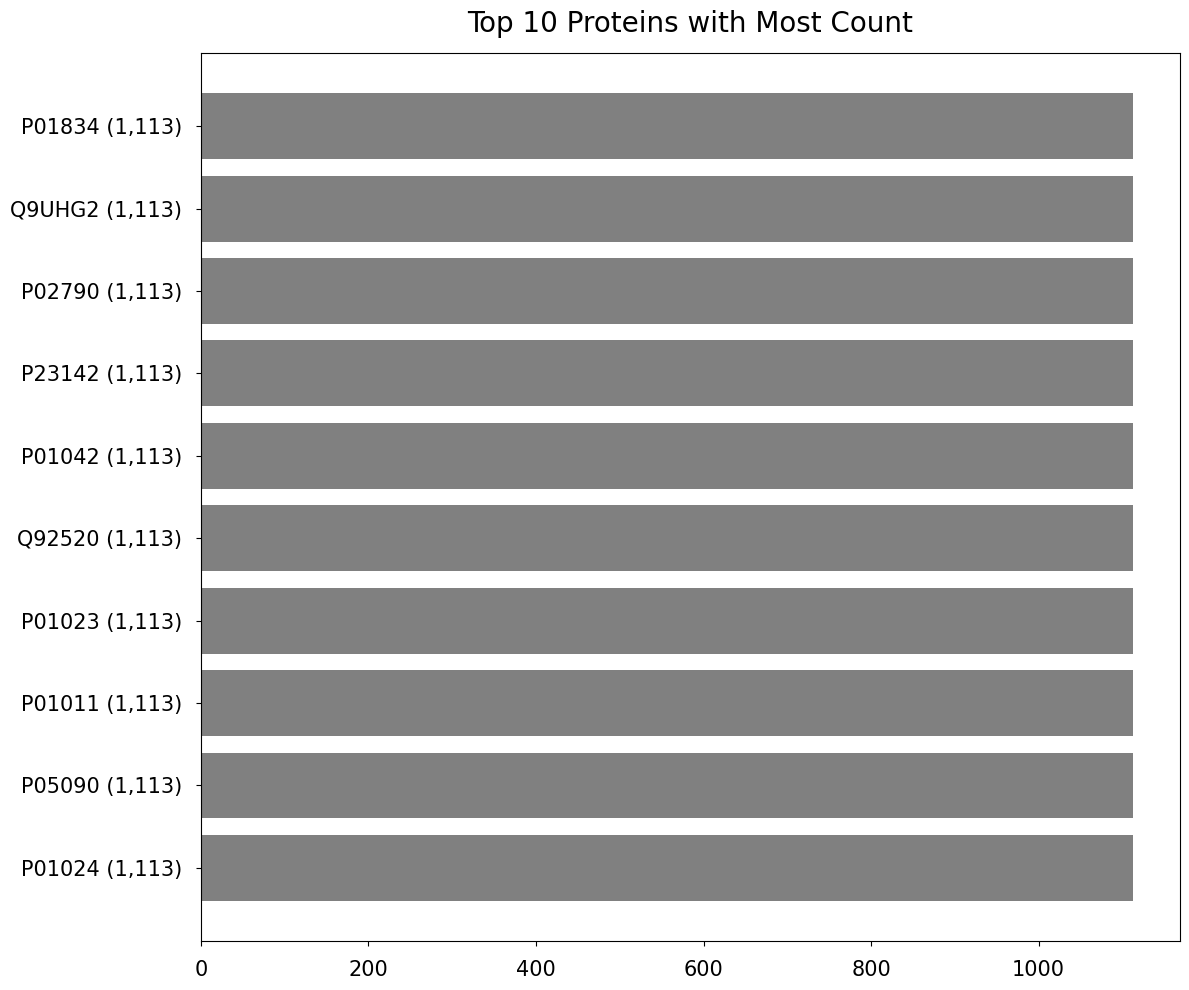

In [14]:
uniprot_value_counts = proteins['UniProt'].value_counts().head(10).to_dict()
visualize_value_counts(uniprot_value_counts, 'Top 10 Proteins with Most Count', pltname="top10proteins.tiff")

In [15]:
uniprot_value_counts
examine_prots = [i for i in uniprot_value_counts.keys()]

In [ ]:
examine_prots

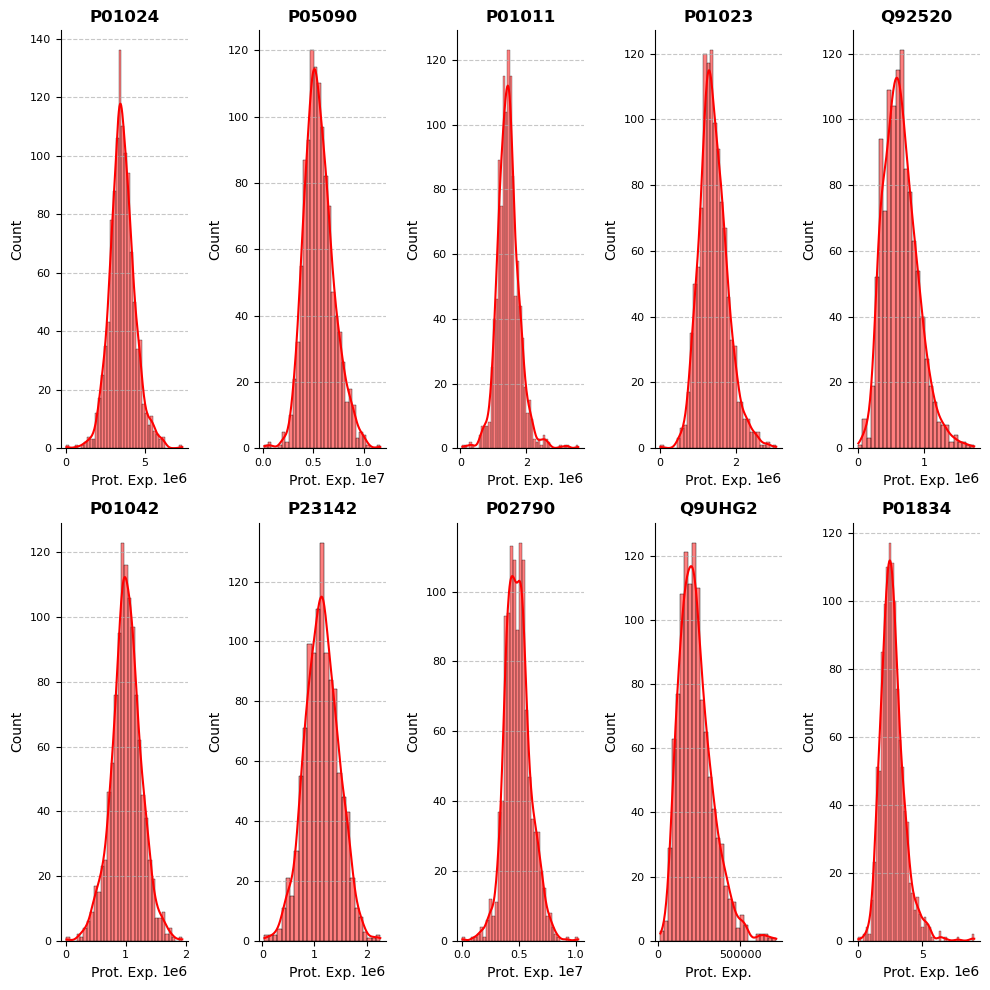

In [16]:
prots = proteins['UniProt'].unique()
#examine_proteins = 8

fig, axes = plt.subplots(1, 10, figsize=(10, 10))

#colors = ["#FFC300", "#FF5733", "#C70039", "#900C3F", "#581845", "#034EA2", "#028090", "#F45B69"]
j = 0
for i in examine_prots[0:10]:
    
    ax = plt.subplot(2, 5, j + 1)
    #splot = sns.boxenplot(proteins[proteins['UniProt'] == i]['NPX'].values, color='grey')
    splot = sns.histplot(proteins[proteins['UniProt'] == i]['NPX'].values,kde=True, alpha=0.5, ec='black')
    #splot = sns.histplot(ax=axes[1][0], x=clinical_data['updrs_1'], kde=True, alpha=0.5, ec='black')
    #splot.set_xlabel('Score')
    #splot.set_ylabel('Count')
    #splot.set_title('UPDRS_1')

    ax.set_title(i, fontsize=12, fontweight='bold')
    ax.set_xlabel('Prot. Exp.', fontsize=10)
    #ax.set_ylabel('NPX', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    sns.despine(top=True, right=True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.gca().invert_yaxis()
    j +=1
plt.tight_layout()
fig.savefig("boxplottop10proteins.tiff")
#plt,show()

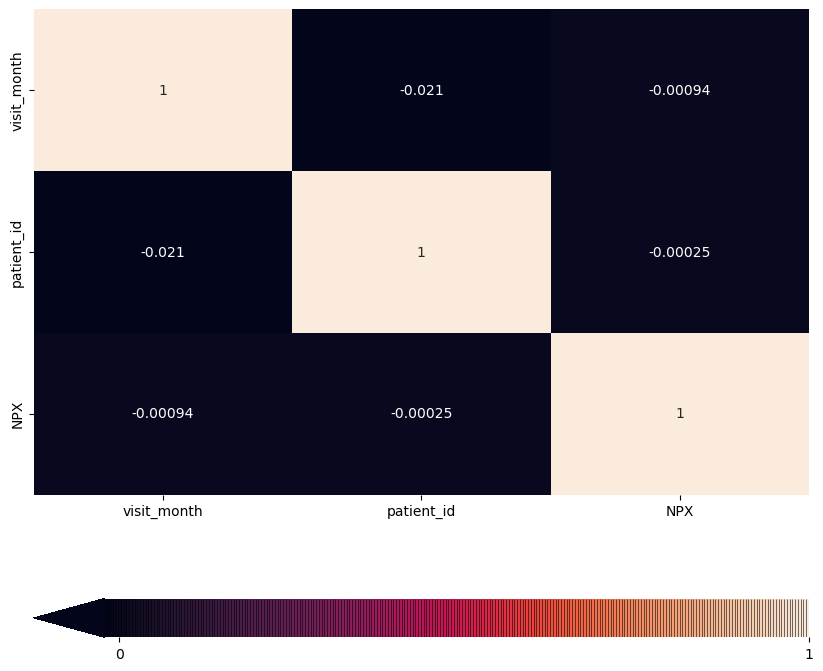

In [17]:
f = plt.figure(figsize=(10,9))
cbar_kws={
    'orientation':'horizontal',
    'shrink':1,
    'extend':'min',
    'extendfrac':0.1,
    'ticks':np.arange(0,22),
    'drawedges':True
}
sns.heatmap(proteins.corr(),annot=True,cbar_kws=cbar_kws)
plt.show()
#f.savefig('correlations.tiff')


In [ ]:
#More peptides EDA

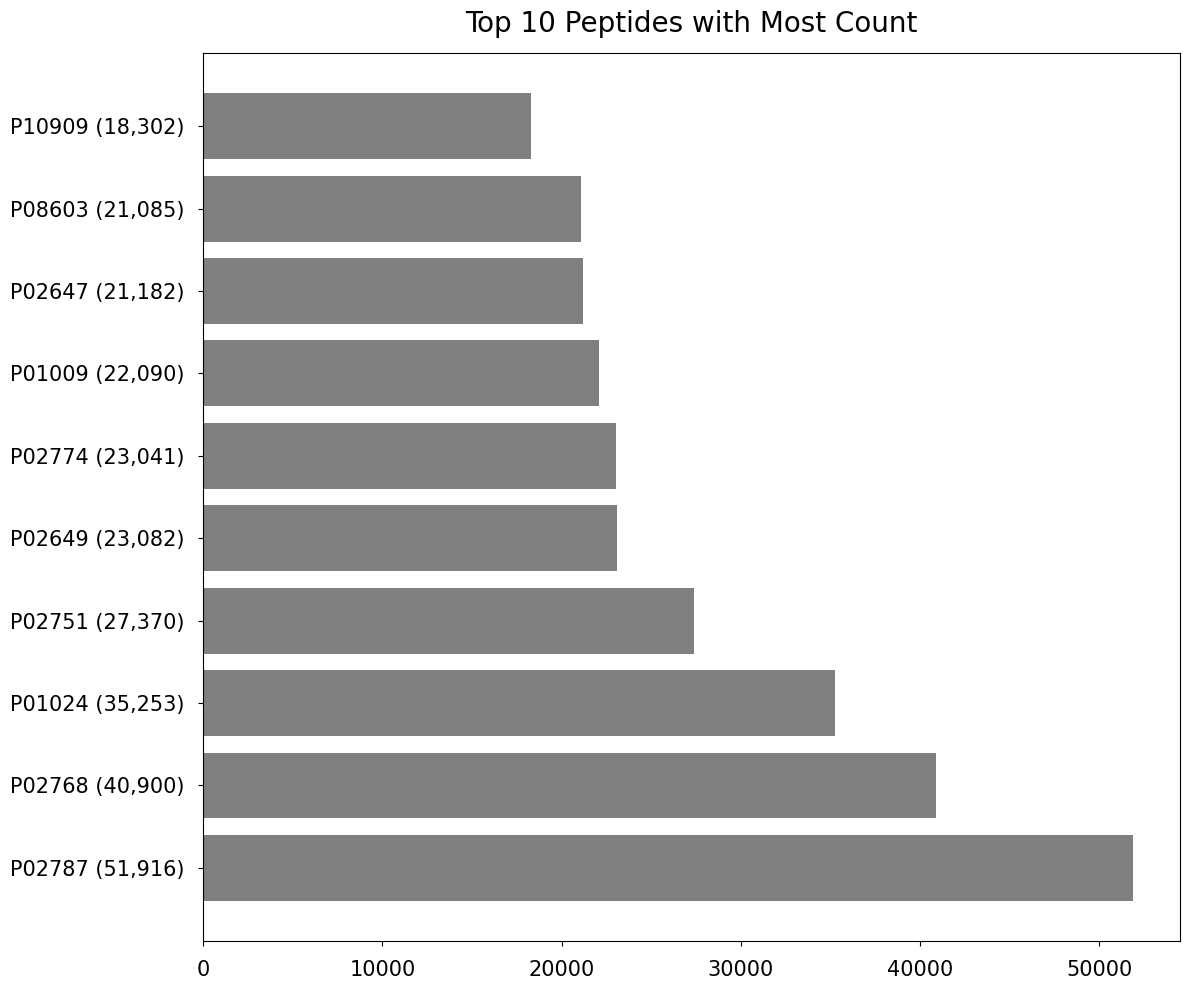

In [18]:
uniprot_value_counts = peptides['UniProt'].value_counts().head(10).to_dict()
visualize_value_counts(uniprot_value_counts, 'Top 10 Peptides with Most Count', pltname="top10peptides.tiff")

In [19]:
uniprot_value_counts
examine_prots = [i for i in uniprot_value_counts.keys()]

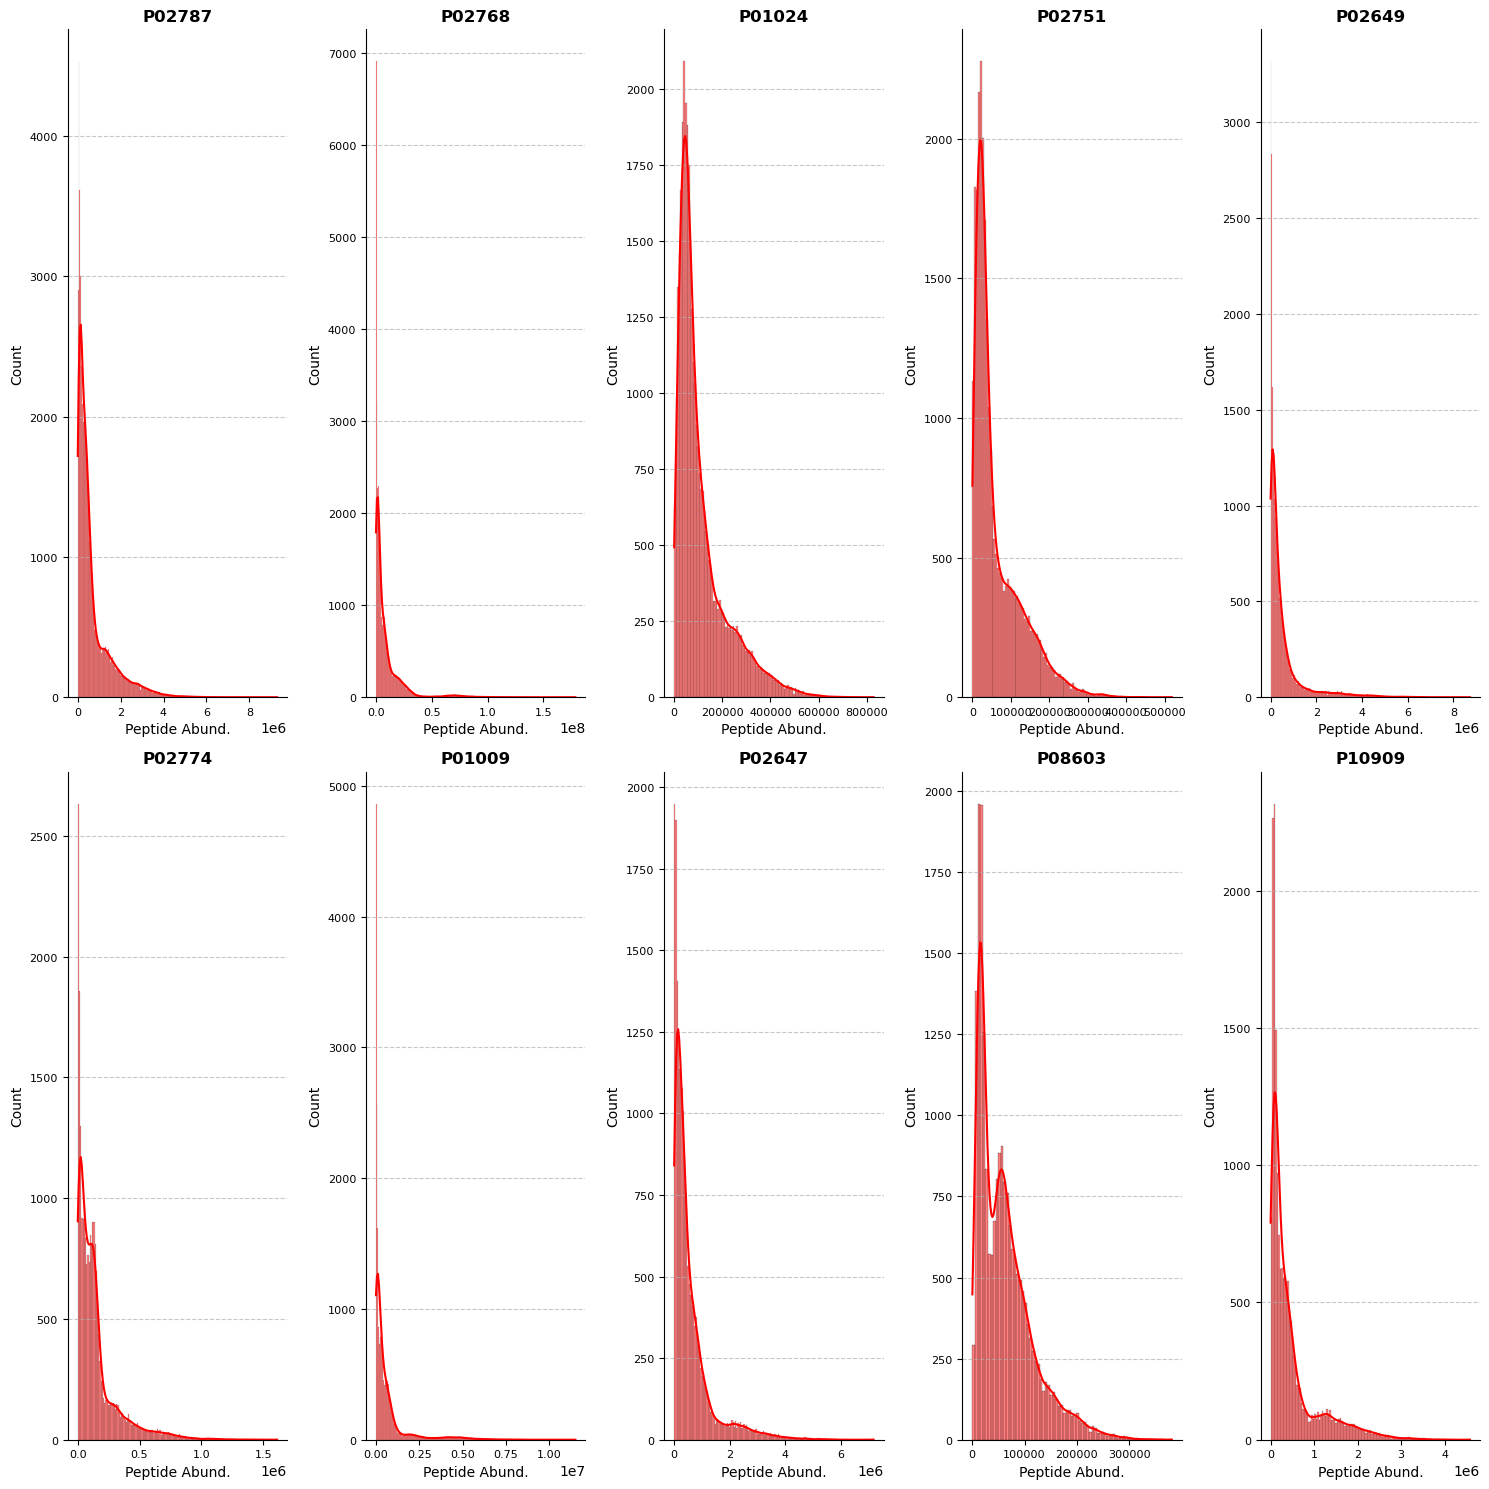

In [20]:
prots = proteins['UniProt'].unique()
#examine_proteins = 8

fig, axes = plt.subplots(1, 10, figsize=(15, 15))

#colors = ["#FFC300", "#FF5733", "#C70039", "#900C3F", "#581845", "#034EA2", "#028090", "#F45B69"]
j = 0
for i in examine_prots[0:10]:
    
    ax = plt.subplot(2, 5, j + 1)
    #splot = sns.boxenplot(proteins[proteins['UniProt'] == i]['NPX'].values, color='grey')
    splot = sns.histplot(peptides[peptides['UniProt'] == i]['PeptideAbundance'].values,kde=True, alpha=0.5, ec='black')
    #splot = sns.histplot(ax=axes[1][0], x=clinical_data['updrs_1'], kde=True, alpha=0.5, ec='black')
    #splot.set_xlabel('Score')
    #splot.set_ylabel('Count')
    #splot.set_title('UPDRS_1')

    ax.set_title(i, fontsize=12, fontweight='bold')
    ax.set_xlabel('Peptide Abund.', fontsize=10)
    #ax.set_ylabel('NPX', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    sns.despine(top=True, right=True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.gca().invert_yaxis()
    j +=1
plt.tight_layout()
fig.savefig("boxplottop10peptides.tiff")
#plt,show()

In [ ]:
########

In [ ]:
peptides.head()
peptides.tail()
clinical_data.shape, proteins.shape, peptides.shape

In [ ]:
len(peptides['Peptide'].unique()), len(peptides['patient_id'].unique())
#peptides.shape
len(proteins['UniProt'].unique()), len(peptides['UniProt'].unique()),  len(proteins['patient_id'].unique())
len(proteins['patient_id'].unique()), len(peptides['patient_id'].unique())
proteins.dtypes

In [ ]:
#exploring uniqueness of UniProt
#55_0
proteins_55 = proteins[proteins["visit_id"]=='55_0']
proteins_55

In [ ]:
peptides_55 = peptides[peptides["visit_id"]=='55_0']
peptides_55

In [ ]:
len(peptides_55['UniProt'].unique()), len(proteins_55['UniProt'].unique())

In [21]:
#peptides.head()
peptides['PeptideAbundance'] = np.log10(peptides['PeptideAbundance'])
proteins['NPX'] = np.log10(proteins['NPX'])

In [25]:
#as seen above, we have 227 unique uniprot for proteins and peptides
#and there are 248 patients

peptides_gb = peptides.groupby(['visit_id','visit_month','patient_id','UniProt'])\
.agg(peptide_mean=("PeptideAbundance",'mean')).reset_index()
peptides_gb['UniProt_peptide'] = peptides_gb['UniProt']+"peptide"
peptides_gb = peptides_gb.drop(['UniProt'],axis=1)
peptides_gb.head()

,visit_id,visit_month,patient_id,peptide_mean,UniProt_peptide
0,10053_0,0,10053,3.959245,O00391peptide
1,10053_0,0,10053,4.668973,O00533peptide
2,10053_0,0,10053,3.854341,O14773peptide
3,10053_0,0,10053,3.397565,O14791peptide
4,10053_0,0,10053,4.609387,O15240peptide


In [26]:
peptides_piv = peptides_gb.pivot(index=['visit_id','visit_month',"patient_id"],
                                columns='UniProt_peptide', values='peptide_mean').\
reset_index().rename_axis(None, axis=1)

In [27]:
#went with mean imputation after testing median imputation as well
#add peptide to peptide name

peptides_piv.isna().sum()
peptides_piv.shape[0]*.10

111.30000000000001

In [28]:
peptides_piv = peptides_piv.dropna(thresh=peptides_piv.shape[0]*0.9,how='all',axis=1)
peptides_piv = peptides_piv.fillna(peptides_piv.median())
peptides_piv = peptides_piv.drop(['visit_month','patient_id'],axis=1)

In [30]:
protein_piv = proteins.pivot(index=['visit_id','visit_month',"patient_id"],
                                columns='UniProt', values='NPX').\
reset_index().rename_axis(None, axis=1)
protein_piv.isna().sum()

In [31]:
protein_piv = protein_piv.dropna(thresh=protein_piv.shape[0]*0.9,how='all',axis=1)
protein_piv = protein_piv.fillna(protein_piv.median())
protein_piv = protein_piv.drop(['visit_month','patient_id'],axis=1)

In [36]:
clinical2 = clinical.copy()
dummies = pd.get_dummies(clinical2.upd23b_clinical_state_on_medication)
 
# Concatenate dummies to original dataframe
clinical2 = pd.concat([clinical2, dummies], axis='columns')
 
# drop ori med col values
clinical2 = clinical2.drop(['upd23b_clinical_state_on_medication'], axis='columns')

In [37]:
merged_df = clinical2.merge(protein_piv, how='inner',on='visit_id')
merged_df = merged_df.merge(peptides_piv, how='inner', on='visit_id')

In [39]:
features = merged_df.iloc[:,7:].columns.tolist()

In [ ]:
#feature dat above

In [40]:
#smape error metric
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [128]:
#updrs_1
ts = merged_df.copy()
ts = ts.sort_values("visit_month", ascending=True)


#X = merged_df[features]
#Y = merged_df['updrs_1']

X = ts[features]
Y = ts['updrs_1']

In [130]:
fs = SelectKBest(score_func=mutual_info_regression, k=50)
X_new = fs.fit_transform(X, Y)
names = X.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['features', 'MI_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['MI_Scores', 'features'], ascending = [False, True])

<Figure size 640x480 with 0 Axes>

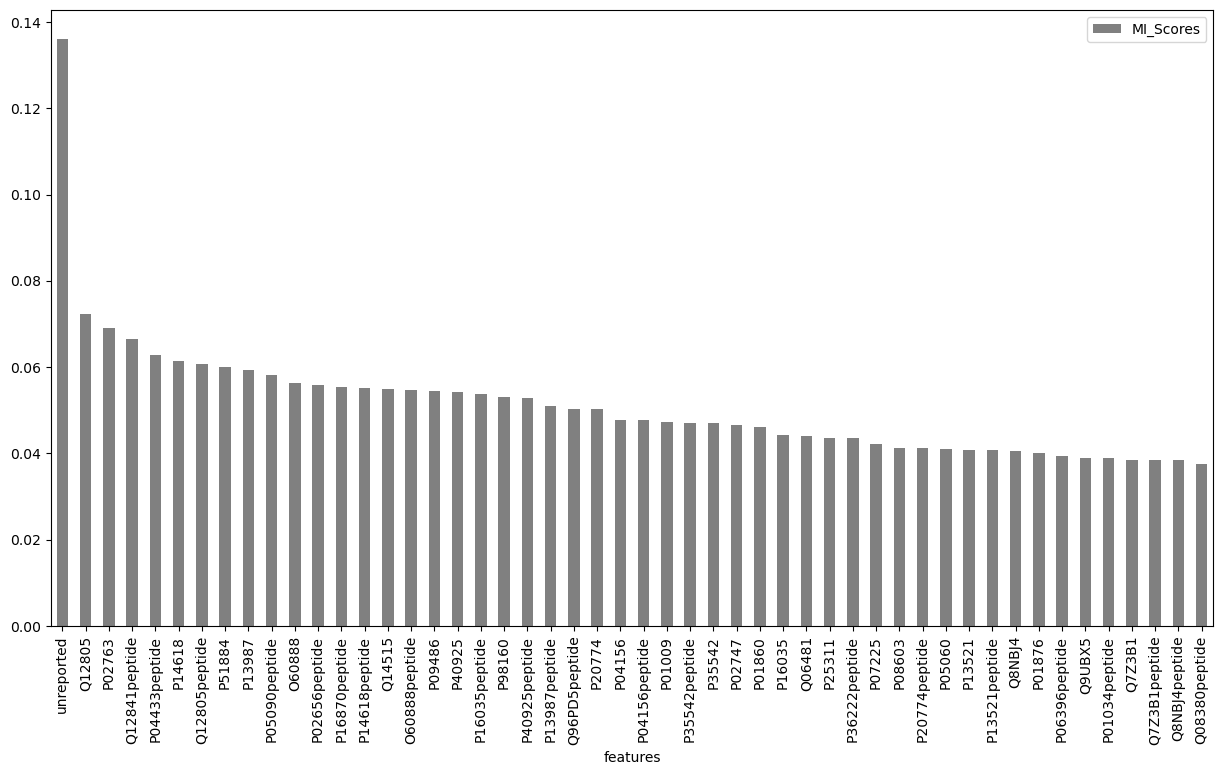

In [131]:
f = plt.figure()
ns_df_sorted.plot.bar(x='features',y='MI_Scores',figsize=(15,8), color="grey")
f.savefig("updrs_1_mi_featuresel.tiff")
# plt.show()

In [132]:
ns_df_sorted.head()
mi_features_updrs1 = ns_df_sorted['features'].tolist()

In [133]:
#mi_features_updrs1

In [136]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X,Y)

RandomForestRegressor(random_state=0)

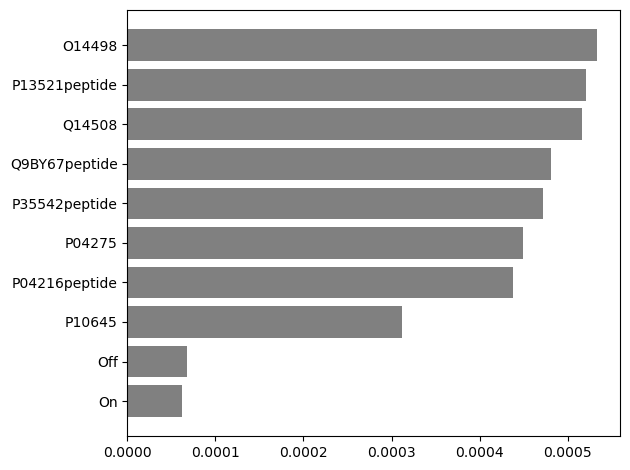

In [137]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f = plt.figure()
plt.barh([x[0] for x in f_i[0:10]],[x[1] for x in f_i[0:10]], color="grey")
plt.tight_layout()
f.savefig("updrs_1_randomforestfeaturesel.tiff")
#plt.show()

In [138]:
updated_features = [x[0] for x in f_i[0:50]]

In [141]:
#time series cross validation
tscv = TimeSeriesSplit(n_splits=10)

In [200]:
y = ts['updrs_1']
X = ts[updated_features]

In [201]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [202]:
model = {}
#mms = MinMaxScaler()
n_estimators = list(range(5,100)) # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = list(range(2,11)) # minimum sample number to split a node
min_samples_leaf = list(range(1,10)) # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
    

In [203]:
forest_params = [{'n_estimators': n_estimators,

    'max_features': max_features,

    'max_depth': max_depth,

    'min_samples_split': min_samples_split,

    'min_samples_leaf': min_samples_leaf,

    'bootstrap': bootstrap}]

linear_params = [{'alpha':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]}]

tree_params = [{

    'max_features': max_features,

    'max_depth': max_depth,

    'min_samples_split': min_samples_split,

    'min_samples_leaf': min_samples_leaf}]

xgb_params = [{'n_estimators': n_estimators,
               
               'learning_rate':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],

    'max_depth': max_depth
    }]

In [204]:
#these are the four algorithms explore
rfc = RandomForestRegressor() 
dt = DecisionTreeRegressor()
xg = XGBRegressor()
ln = Lasso()

In [205]:
#cv = KFold(n_splits=10, shuffle=True, random_state=42)
rf = RandomizedSearchCV(rfc, forest_params, cv = tscv, scoring=make_scorer(smape), verbose = -1)
linear = RandomizedSearchCV(ln, linear_params, cv = tscv, scoring=make_scorer(smape), verbose = -1)
dec = RandomizedSearchCV(dt, tree_params, cv = tscv, scoring=make_scorer(smape), verbose = -1)
xgb = RandomizedSearchCV(xg, xgb_params, cv = tscv, scoring=make_scorer(smape), verbose = -1)

In [206]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


print('rfc best params:',rf.best_params_)

print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)


xgb best params: {'n_estimators': 9, 'max_depth': 50, 'learning_rate': 0.03}
xgb best score 109.54722337656412
rfc best params: {'n_estimators': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}
rfc best score 83.06410182514226
decision tree best param {'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 70}
decision tree best score 84.62002119634181
linear best param {'alpha': 0.01}
linear best score 69.24970206995829


In [207]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 102.66119022191815 mse: 60.432896197697005 mae: 5.66557376870175
RF related errors- smape: 70.26282845056699 mse: 42.200864833906074 mae: 4.819587628865979
Dec related errors- smape: 73.1025693487924 mse: 43.201758304696455 mae: 4.856013745704467
Linear related errors- smape: 58.560357373914954 mse: 29.38978985100502 mae: 4.075988799438225


In [208]:
model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                   
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [209]:
ypred = model.predict(X_test)

In [210]:
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)

In [211]:
error, mse, mae


(56.1170037560198, 28.841911888478712, 3.947127986200077)

In [212]:
y = ts['updrs_1']
X = ts[mi_features_updrs1]

In [213]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [214]:
model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                  
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae

(53.80435949640759, 29.011822394896964, 3.8430908340768717)

In [215]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


print('rfc best params:',rf.best_params_)

print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)


xgb best params: {'n_estimators': 17, 'max_depth': 40, 'learning_rate': 0.02}
xgb best score 103.96451447386107
rfc best params: {'n_estimators': 44, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
rfc best score 76.91715314988805
decision tree best param {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60}
decision tree best score 82.75709195266236
linear best param {'alpha': 0.01}
linear best score 68.39426638688767


In [216]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 100.93987111360225 mse: 58.322311473479935 mae: 5.598621271012985
RF related errors- smape: 71.42487028211603 mse: 41.12237277851762 mae: 4.658878177950342
Dec related errors- smape: 77.70933796257748 mse: 50.36082474226804 mae: 5.233676975945016
Linear related errors- smape: 58.50434097557016 mse: 28.781960891688254 mae: 4.109312175938617


In [ ]:
#looking at other updrs_....2,3.4

In [217]:
#Feature selection for each updrs
#updrs -2 
ts_2 = merged_df.copy()
ts_2 = ts_2.sort_values("visit_month", ascending=True)

Xfeat = ts_2[features]
Yfeat = ts_2['updrs_2']


In [218]:
X = Xfeat
Y = Yfeat

fs = SelectKBest(score_func=mutual_info_regression, k=50)
X_new = fs.fit_transform(X, Y)
names = X.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['features', 'MI_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['MI_Scores', 'features'], ascending = [False, True])

<Figure size 640x480 with 0 Axes>

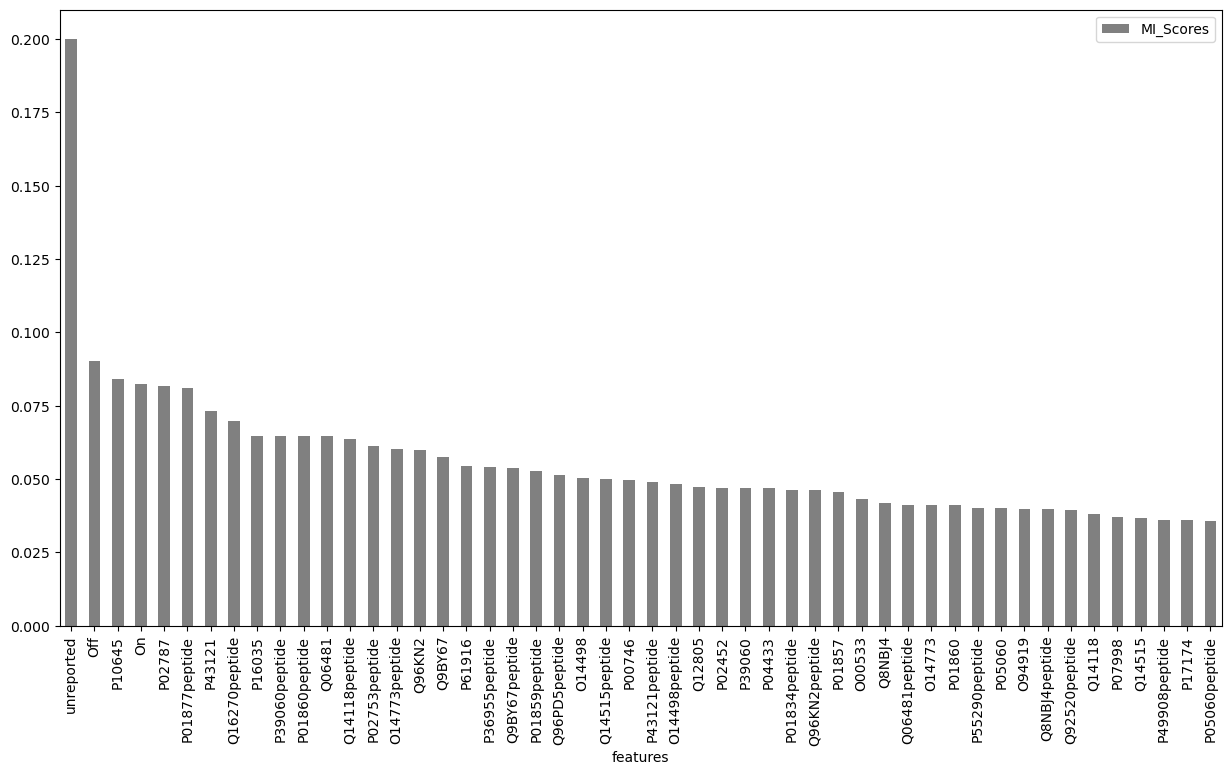

In [219]:
f = plt.figure()
ns_df_sorted.plot.bar(x='features',y='MI_Scores',figsize=(15,8), color="grey")
f.savefig("updrs_2_mi_featuresel.tiff")
# plt.show()

In [220]:
ns_df_sorted.head()
mi_features_updrs2 = ns_df_sorted['features'].tolist()

In [221]:
y = ts_2['updrs_2']
X = ts_2[mi_features_updrs2]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [222]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


print('rfc best params:',rf.best_params_)

print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 13, 'max_depth': 10, 'learning_rate': 0.01}
xgb best score 147.15050367064072
rfc best params: {'n_estimators': 23, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
rfc best score 99.74887232400617
decision tree best param {'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 90}
decision tree best score 102.97191511278388
linear best param {'alpha': 0.01}
linear best score 95.08566259448128


In [223]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 149.59149042429758 mse: 67.70273043168046 mae: 5.75318996408551
RF related errors- smape: 94.64671822705124 mse: 32.51967407456165 mae: 3.9432552133358953
Dec related errors- smape: 95.56400344142403 mse: 31.52291868597035 mae: 4.297654750747534
Linear related errors- smape: 89.12293938292272 mse: 25.171061056819866 mae: 3.787304088127521


In [224]:
model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                  
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error

(89.44501356064528, 27.05550293948909, 3.636849682509285)

In [ ]:
#rf feature selection

In [225]:
rf = RandomForestRegressor(random_state=0)
rf.fit(Xfeat,Yfeat)


RandomForestRegressor(random_state=0)

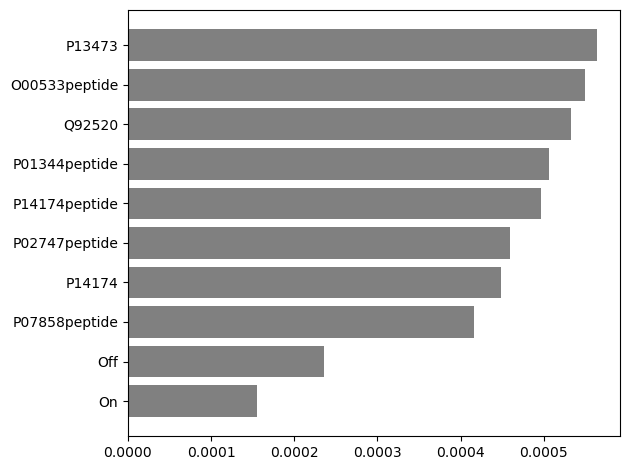

In [226]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f = plt.figure()
plt.barh([x[0] for x in f_i[0:10]],[x[1] for x in f_i[0:10]], color="grey")
plt.tight_layout()
f.savefig("updrs_2_randomforestfeaturesel.tiff")



In [227]:
updated_features = [x[0] for x in f_i[0:50]]
y = ts_2['updrs_2']
X = ts_2[updated_features]


In [229]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


#print('rfc best params:',rf.best_params_)

#print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 5, 'max_depth': 60, 'learning_rate': 0.01}
xgb best score 158.93907453729076
decision tree best param {'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 60}
decision tree best score 102.79474909620997
linear best param {'alpha': 0.01}
linear best score 95.08566259448128


In [230]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 161.05808932710175 mse: 74.4673612071998 mae: 6.0600458030233675
RF related errors- smape: 86.86904974738584 mse: 24.270815463917526 mae: 3.4926804123711337
Dec related errors- smape: 91.95797908130318 mse: 37.79383842817979 mae: 4.395431716050273
Linear related errors- smape: 89.12293938292272 mse: 25.171061056819866 mae: 3.787304088127521


In [231]:
#y = ts['updrs_2']
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                  
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error  


(90.29482576071409, 26.890595989908498, 3.8399332852400456)

In [ ]:
################## updrs 3

In [232]:
#merged_df['updrs_3'].isna().sum()

ts_3 = merged_df.copy()
ts_3 = ts_3.sort_values("visit_month", ascending=True)

ts_3 = ts_3.dropna(subset=['updrs_3'])
Xfeat = ts_3[features]
Yfeat = ts_3['updrs_3']

<Figure size 640x480 with 0 Axes>

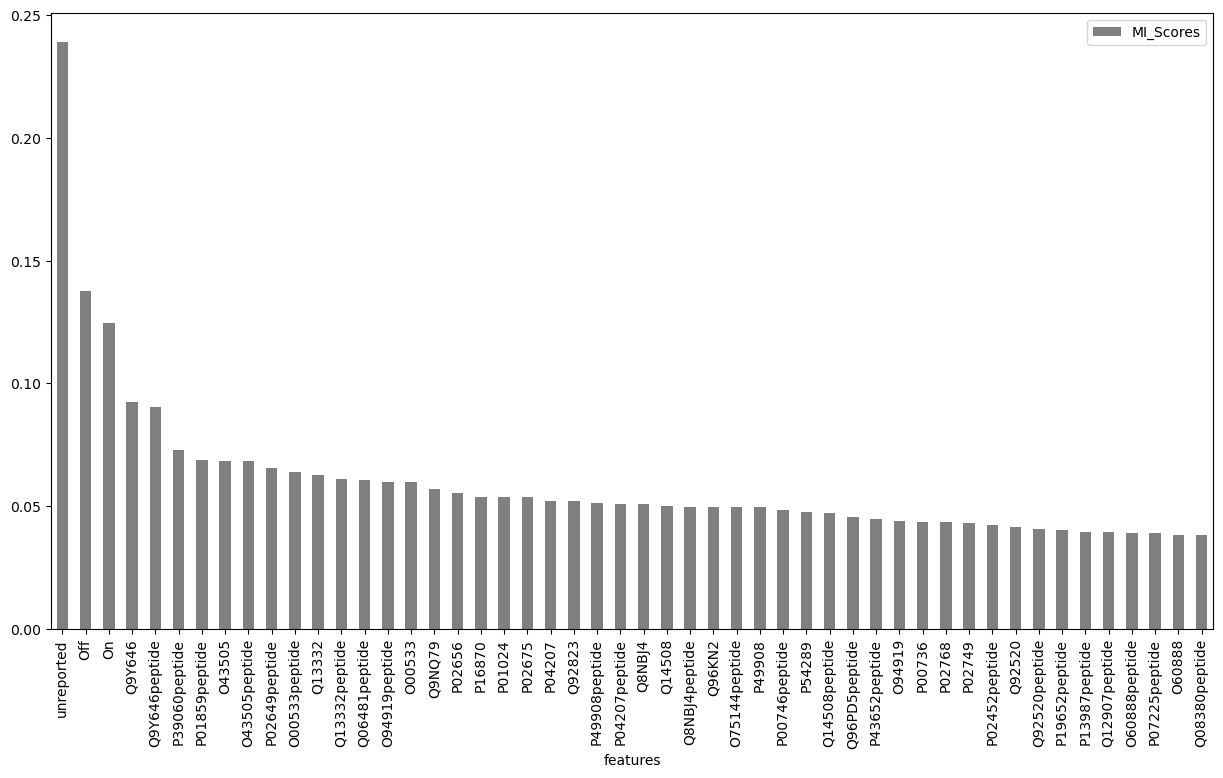

In [233]:
X = Xfeat
Y = Yfeat

fs = SelectKBest(score_func=mutual_info_regression, k=50)
X_new = fs.fit_transform(X, Y)
names = X.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['features', 'MI_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['MI_Scores', 'features'], ascending = [False, True])
f = plt.figure()
ns_df_sorted.plot.bar(x='features',y='MI_Scores',figsize=(15,8), color="grey")
f.savefig("updrs_3_mi_featuresel.tiff")

In [234]:
ns_df_sorted.head()
mi_features_updrs3 = ns_df_sorted['features'].tolist()
y = ts_3['updrs_3']
X = ts_3[mi_features_updrs3]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                  
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error

(79.02660577614361, 140.22135878505554, 9.563784068392724)

In [237]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


#print('rfc best params:',rf.best_params_)

#print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 7, 'max_depth': 110, 'learning_rate': 0.02}
xgb best score 151.42474494169497
decision tree best param {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 50}
decision tree best score 93.68012278991839
linear best param {'alpha': 0.01}
linear best score 86.19564052298873


In [238]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 154.61382882334175 mse: 574.894753587166 mae: 18.144892762309496
RF related errors- smape: 79.73419565782882 mse: 135.9778268041237 mae: 9.69278350515464
Dec related errors- smape: 75.22445676211974 mse: 186.41527491408934 mae: 10.327147766323025
Linear related errors- smape: 77.42864708261773 mse: 128.03451229544012 mae: 9.480003126325649


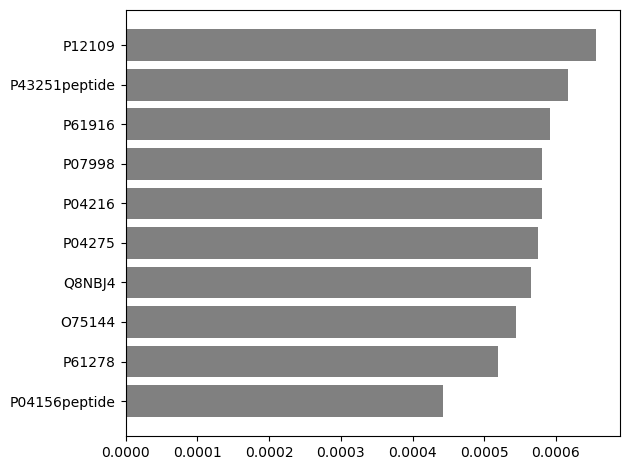

In [239]:
#updrs_3
#ts_3 = tsmerged_df.copy()

rf = RandomForestRegressor(random_state=0)
rf.fit(Xfeat,Yfeat)

f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f = plt.figure()
plt.barh([x[0] for x in f_i[0:10]],[x[1] for x in f_i[0:10]], color="grey")
plt.tight_layout()
f.savefig("updrs_3_randomforestfeaturesel.tiff")


In [240]:
#ts = updrs_3.copy()
#ts = ts.sort_values("visit_month", ascending=True)
tscv = TimeSeriesSplit(n_splits=10)


In [241]:
updated_features = [x[0] for x in f_i[0:50]]
y = ts_3['updrs_3']
X = ts_3[updated_features]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model = XGBRegressor(n_estimators=1000, max_depth=40, learning_rate=0.01) 
#model = XGBRegressor()
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error  


(95.52284622942139, 285.4048666822481, 14.214767891107146)

In [243]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


#print('rfc best params:',rf.best_params_)

#print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 18, 'max_depth': 60, 'learning_rate': 0.01}
xgb best score 148.00112886023982
decision tree best param {'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 60}
decision tree best score 108.52125745346908
linear best param {'alpha': 0.01}
linear best score 90.62715631623772


In [244]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 153.4550640722907 mse: 604.4803693505468 mae: 18.58853640445729
RF related errors- smape: 94.3358166873049 mse: 260.35739381443295 mae: 13.824948453608247
Dec related errors- smape: 110.72044761206261 mse: 454.01639175257736 mae: 16.883161512027492
Linear related errors- smape: 97.17390102418541 mse: 288.97809310333264 mae: 14.676046420983958


In [ ]:
###################### updrs 4

In [250]:
#updrs_4
ts_4 = merged_df.copy()
ts_4 = ts_4.sort_values("visit_month", ascending=True)

#updrs_4 = merged_df.copy()
ts_4 = ts_4.dropna(subset=['updrs_4'])
Xfeat = ts_4[features]
Yfeat = ts_4['updrs_4']



<Figure size 640x480 with 0 Axes>

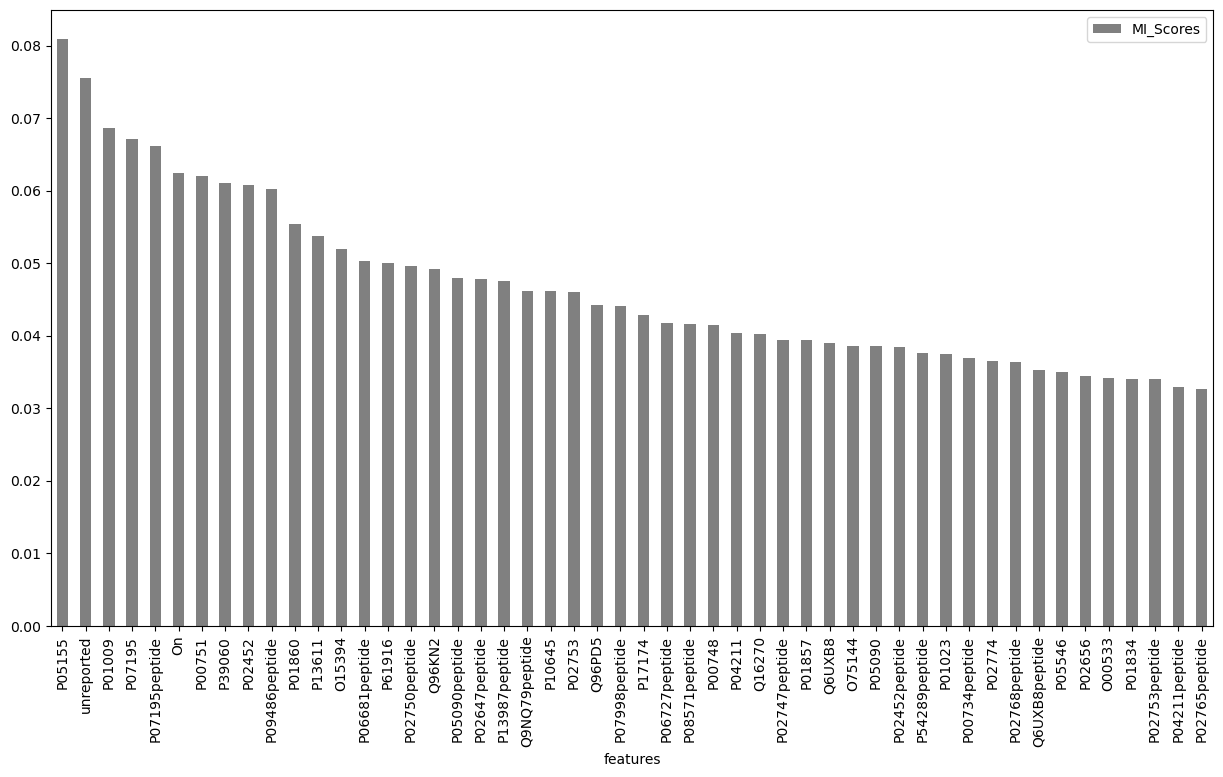

In [251]:
X = Xfeat
Y = Yfeat

fs = SelectKBest(score_func=mutual_info_regression, k=50)
X_new = fs.fit_transform(X, Y)
names = X.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['features', 'MI_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['MI_Scores', 'features'], ascending = [False, True])
f = plt.figure()
ns_df_sorted.plot.bar(x='features',y='MI_Scores',figsize=(15,8), color="grey")
f.savefig("updrs_4_mi_featuresel.tiff")

In [252]:
ns_df_sorted.head()
mi_features_updrs4 = ns_df_sorted['features'].tolist()
y = ts_4['updrs_4']
X = ts_4[mi_features_updrs4]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01)                  
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error

(123.3735538245262, 10.01683071020693, 2.3020675970862308)

In [254]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


#print('rfc best params:',rf.best_params_)

#print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 25, 'max_depth': 70, 'learning_rate': 0.02}
xgb best score 171.68447292648352
decision tree best param {'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 90}
decision tree best score 127.33044490053335
linear best param {'alpha': 0.01}
linear best score 155.30999807268486


In [255]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 140.34785153580228 mse: 13.252904009023208 mae: 2.6710639934913787
RF related errors- smape: 118.3971007467405 mse: 10.24709019607843 mae: 2.463137254901961
Dec related errors- smape: 136.1281652905658 mse: 16.27958022190377 mae: 3.0835185511656102
Linear related errors- smape: 119.43104427674676 mse: 10.874669453570236 mae: 2.584162128125074


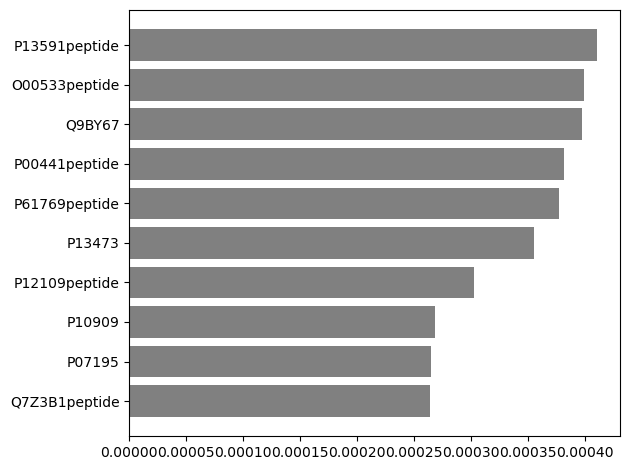

In [256]:
########

rf = RandomForestRegressor(random_state=0)
rf.fit(Xfeat,Yfeat)

f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f = plt.figure()
plt.barh([x[0] for x in f_i[0:10]],[x[1] for x in f_i[0:10]], color="grey")
plt.tight_layout()
f.savefig("updrs_4_randomforestfeaturesel.tiff")


In [257]:
#ts = updrs_3.copy()
#ts = ts.sort_values("visit_month", ascending=True)
tscv = TimeSeriesSplit(n_splits=10)

In [259]:
updated_features = [x[0] for x in f_i[0:50]]
y = ts_4['updrs_4']
X = ts_4[updated_features]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model = XGBRegressor(n_estimators=1000, max_depth=40, learning_rate=0.01) 
#model = XGBRegressor()
model.fit(X_train, y_train)
ypred = model.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
error, mse, mae
#error  

(140.3879522544616, 13.097265171423818, 2.8646685303572346)

In [261]:
xgb.fit(X_train,y_train)
rf.fit(X_train, y_train)
dec.fit(X_train,y_train)
linear.fit(X_train,y_train)

print('xgb best params:',xgb.best_params_)

print('xgb best score',xgb.best_score_)


#print('rfc best params:',rf.best_params_)

#print('rfc best score',rf.best_score_)


print('decision tree best param',dec.best_params_)

print('decision tree best score',dec.best_score_)


print('linear best param',linear.best_params_)

print('linear best score',linear.best_score_)

xgb best params: {'n_estimators': 56, 'max_depth': 110, 'learning_rate': 0.02}
xgb best score 170.7462899821346
decision tree best param {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 80}
decision tree best score 142.63223459093663
linear best param {'alpha': 0.01}
linear best score 159.41603685731923


In [262]:
#err_fn(xgb)
ypred = xgb.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("XGB related errors-","smape:",error,"mse:",mse,"mae:",mae,)
#error
ypred = rf.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("RF related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = dec.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Dec related errors-","smape:",error,"mse:",mse,"mae:",mae,)

ypred = linear.predict(X_test)
error = smape(y_test,ypred)
mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
print("Linear related errors-","smape:",error,"mse:",mse,"mae:",mae,)

XGB related errors- smape: 149.07603841372065 mse: 14.885474206711928 mae: 2.9984539148269915
RF related errors- smape: 129.04979682499453 mse: 11.860476470588237 mae: 2.7747058823529414
Dec related errors- smape: 124.43329450804129 mse: 15.866424272496692 mae: 3.0795611251493606
Linear related errors- smape: 122.46126961229777 mse: 11.695403281460592 mae: 2.829758366044921
